In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.8.0
Pandas Version: 1.3.3
Numpy Version: 1.23.5
System Version: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]


In [2]:
# Data Loader Parameters
BATCH_SIZE = 256
BUFFER_SIZE = 10000
TRAIN_SPLIT = 300000

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 4
PATIENCE = 5

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

In [4]:
from sklearn import preprocessing

def fullRead(pathToTable, sep, anthro = False):

  df_renamed = pd.read_csv(pathToTable, sep = sep, encoding = "latin_1")


  # reading and merging    
  
  if anthro == True:
    df_anthro = pd.read_csv("data/chronicAnthropometricCardiovascularData.csv", sep=";", decimal=",")
    df_renamed = df_renamed.merge(df_anthro)

    # separating by time moment and renaming

    df_renamed["Weight"] = ""
    df_renamed["BMI"] = ""
    df_renamed["Fat"] = ""
    df_renamed["CVRI"] = ""
    df_renamed["Bpmin"] = ""
    df_renamed["Bpmax"] = ""
    df_renamed["Frec"] = ""

    for i in range(len(df_renamed)):

        if df_renamed.loc[i]["Time"] == "Initial":
            df_renamed.loc[i,"Weight"] = df_renamed.loc[i]["Peso inicial"]
            df_renamed.loc[i,"BMI"] = df_renamed.loc[i]["IMC Inicial"]
            df_renamed.loc[i,"Fat"] = df_renamed.loc[i]["Grasa inicial"]
            df_renamed.loc[i,"CVRI"] = df_renamed.loc[i]["IRCV inicial"] 
            df_renamed.loc[i,"Bpmin"] = df_renamed.loc[i]["Bpmin inicial"] 
            df_renamed.loc[i,"Bpmax"] = df_renamed.loc[i]["Bpmax inicial"] 
            df_renamed.loc[i,"Frec"] = df_renamed.loc[i]["Frec inicial"] 
                
        if df_renamed.loc[i]["Time"] == "Final":
        
            df_renamed.loc[i,"Weight"] = df_renamed.loc[i]["Peso final"]
            df_renamed.loc[i,"BMI"] = df_renamed.loc[i]["IMC Final"]
            df_renamed.loc[i,"Fat"] = df_renamed.loc[i]["Grasa final"]
            df_renamed.loc[i,"CVRI"] = df_renamed.loc[i]["IRCV Final"] 
            df_renamed.loc[i,"Bpmin"] = df_renamed.loc[i]["Bpmin final"] 
            df_renamed.loc[i,"Bpmax"] = df_renamed.loc[i]["Bpmax final"] 
            df_renamed.loc[i,"Frec"] = df_renamed.loc[i]["Frec final"] 
        
    df_renamed.drop(columns = ["Peso inicial", "Peso final", "Delta Peso", "Talla", "IMC Inicial", "IMC Final", "Delta IMC", "Grasa inicial", "Grasa final", "Delta Grasa", "IRCV Final", "IRCV inicial", "Bpmin final", "Bpmin inicial", "Bpmax final", "Bpmax inicial", "Frec final", "Frec inicial",], inplace=True )
  
  df_renamed.drop(columns = ["Unnamed: 0", "grouping"], inplace=True )
  df_renamed.fillna(0, inplace=True)
  return df_renamed

def scaling(df_read):
   
   scaler = preprocessing.MinMaxScaler()
   numCols = df_read.select_dtypes(include=np.number).drop("numVol",1).columns
   df_read[numCols] = scaler.fit_transform(df_read[numCols])
   return df_read

df = scaling(fullRead("../data/urineAnt_ord.csv", sep = ","))

print("DataFrame Shape: {} rows, {} columns".format(*df.shape))
display(df.head())

DataFrame Shape: 250 rows, 25 columns


C:\Users\Cristina García\AppData\Local\Temp\ipykernel_14060\3762195158.py:54: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  numCols = df_read.select_dtypes(include=np.number).drop("numVol",1).columns


,numVol,CA,CA.G,CA.S,CA.GS,Total.CA,DHPAA,DHPAA.G,DHPAA.GG,DHPAA.GS,...,Total.TFA,TIFA.Sulfate.1,VA,VA.GG,VA.GS,VA.SS,Total.VA,Sweetener,Time,Sex
0,1,0.019469,0.097610,0.000000,0.600000,0.099345,0.000000,0.000000,0.000000,0.021025,...,0.130242,0.000000,0.038760,0.022277,0.038124,0.000000,0.036225,ST,Initial,WOMAN
1,1,0.040708,0.162777,0.000000,0.800000,0.167948,0.260338,0.153770,0.000000,0.000000,...,0.000379,0.000000,0.051674,0.038366,0.559042,0.033595,0.076563,ST,Final,WOMAN
2,2,0.000000,0.854582,0.000000,0.533333,0.853971,0.179981,0.114795,0.016340,0.049934,...,0.156346,0.065563,0.132059,0.068069,0.100540,0.010078,0.133606,ST,Initial,WOMAN
3,2,0.031858,0.123506,0.143341,0.133333,0.198406,0.491071,0.183281,0.013072,0.232589,...,0.096222,0.037489,0.095116,0.144802,0.361673,0.048899,0.112355,ST,Final,WOMAN
4,3,0.065487,0.020205,0.150113,0.466667,0.103330,0.054511,0.061518,0.016340,0.030223,...,0.075650,0.068243,0.019030,0.309406,0.471660,0.008959,0.042170,ST,Initial,WOMAN


In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
        
    return np.array(data), np.array(labels)

In [6]:
uni_data = df["CA"]
uni_data.index = df["Time"]
uni_data.head()

Time
Initial    0.019469
Final      0.040708
Initial    0.000000
Final      0.031858
Initial    0.065487
Name: CA, dtype: float64

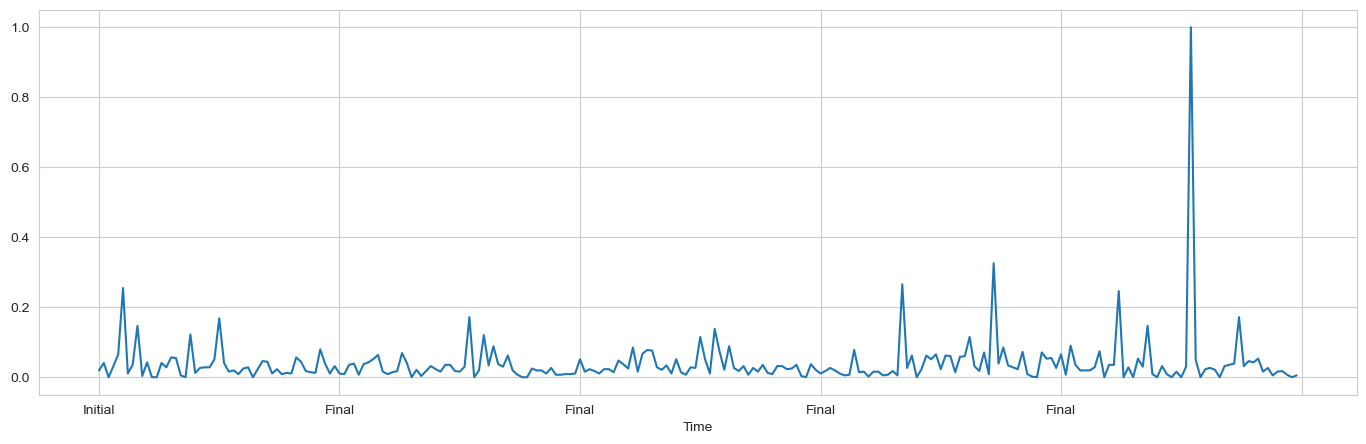

In [7]:
uni_data.plot(subplots=True)
plt.show()
uni_data = uni_data.values

In [11]:
univariate_past_history = 1
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(dataset=uni_data,
                                           start_index=0,
                                           end_index=TRAIN_SPLIT,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)
x_val_uni, y_val_uni = univariate_data(dataset=uni_data,
                                       start_index=TRAIN_SPLIT,
                                       end_index=None,
                                       history_size=univariate_past_history,
                                       target_size=univariate_future_target)

IndexError: index 250 is out of bounds for axis 0 with size 250